# **Coffee Roasting in TensorFlow **



This project focuses on building a prediction model, "Coffee Roasting predictive model ".
The model uses two features, Temperature in Celsius and Duration in minutes, to predict the probability of achieving a good coffee roast. The project follows the guidelines provided by "Coffee Roasting at Home," aiming for a duration between 12 and 15 minutes and a temperature between 175 and 260 degrees Celsius. The model outputs probabilities, and a threshold of 0.5 is applied to make binary decisions.

In [22]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential


Loading DATA


In [23]:
def load_coffee_data():
    """ Creates a coffee roasting data set.
        roasting duration: 12-15 minutes is best
        temperature range: 175-260C is best
    """
    rng = np.random.default_rng(2)
    X = rng.random(400).reshape(-1,2)
    X[:,1] = X[:,1] * 4 + 11.5          # 12-15 min is best
    X[:,0] = X[:,0] * (285-150) + 150  # 350-500 F (175-260 C) is best
    Y = np.zeros(len(X))

    i=0
    for t,d in X:
        y = -3/(260-175)*t + 21
        if (t > 175 and t < 260 and d > 12 and d < 15 and d<=y ):
            Y[i] = 1
        else:
            Y[i] = 0
        i += 1

    return (X, Y.reshape(-1,1))

In [24]:
X,Y = load_coffee_data();
print(X.shape, Y.shape)

(200, 2) (200, 1)


Normalizing data

In [25]:
print(f"Temperature Max, Min pre normalization: {np.max(X[:,0]):0.2f}, {np.min(X[:,0]):0.2f}")
print(f"Duration    Max, Min pre normalization: {np.max(X[:,1]):0.2f}, {np.min(X[:,1]):0.2f}")

Temperature Max, Min pre normalization: 284.99, 151.32
Duration    Max, Min pre normalization: 15.45, 11.51


In [26]:
# normalize data
norm_1 = tf.keras.layers.Normalization(axis=1)
norm_1.adapt(X)
Xn = norm_1(X)
print(f"Temperature Max, Min post normalization: {np.max(Xn[:,0]):0.2f}, {np.min(Xn[:,0]):0.2f}")
print(f"Duration    Max, Min post normalization: {np.max(Xn[:,1]):0.2f}, {np.min(Xn[:,1]):0.2f}")

Temperature Max, Min post normalization: 1.66, -1.69
Duration    Max, Min post normalization: 1.79, -1.70


Fitting the model's weights to the data is more efficient if the data is normalized.

To enhance the training process, we can tile (or duplicate) our data to increase the training set size. This augmentation helps in improving the model's performance and can reduce the number of training epochs required. By expanding the dataset, the model is exposed to more variations of the data, which aids in better generalization and learning.

The steps involved in data augmentation are:

Tile the Data: Duplicate the dataset to artificially increase its size.
Randomize the Data: Shuffle the data to ensure the model sees different variations in each epoch.
By augmenting the data, we can effectively train the model more efficiently and achieve better performance with fewer training epochs.

In [27]:
Xn.shape,Y.shape

(TensorShape([200, 2]), (200, 1))

In [28]:
Xt = np.tile(Xn,(1000,1))
Yt= np.tile(Y,(1000,1))
print(Xt.shape, Yt.shape)

(200000, 2) (200000, 1)


# Plotting the data

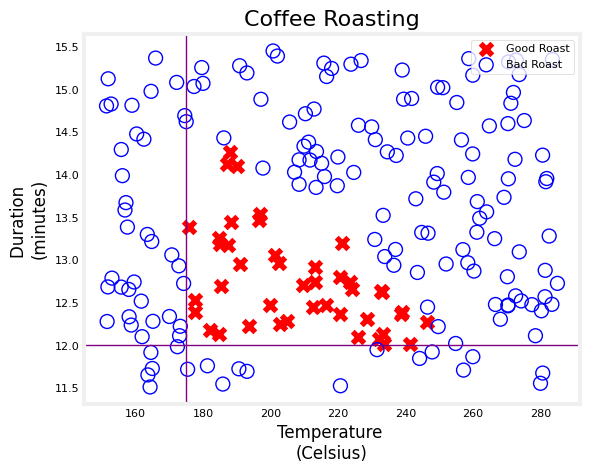

In [29]:
Y = Y.reshape(-1,)
fig, ax = plt.subplots(1,1,)
ax.scatter(X[Y==1,0],X[Y==1,1], s=70, marker='x', c='red', label="Good Roast" )
ax.scatter(X[Y==0,0],X[Y==0,1], s=100, marker='o', edgecolor="blue",facecolor='none',linewidth=1,  label="Bad Roast")
ax.axhline(y=12,color="purple",linewidth=1)
ax.axvline(x=175,color="purple",linewidth=1)
ax.set_title(f"Coffee Roasting", size=16)
ax.set_xlabel("Temperature \n(Celsius)",size=12)
ax.set_ylabel("Duration \n(minutes)",size=12)
ax.legend(loc='upper right')
plt.show()

# TensorFlow Model

In [30]:
tf.random.set_seed(1234)  # applied to achieve consistent results
model = Sequential(
    [
        tf.keras.Input(shape=(2,)),
        Dense(3, activation='sigmoid', name = 'layer1'),
        Dense(1, activation='sigmoid', name = 'layer2')
     ]
)

## tf.keras.Input(shape=(2,))
-specifies the expected shape of the input. This allows TensorFlow to size the weights and bias parameters at this point,

In [31]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ layer1 (Dense)                  │ (None, 3)              │             9 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer2 (Dense)                  │ (None, 1)              │             4 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13 (52.00 B)

 Trainable params: 13 (52.00 B)

 Non-trainable params: 0 (0.00 B)

 The weights and biases Tensorflow has instantiated. The weights  W
  should be of size (number of features in input, number of units in the layer) while the bias b size should match the number of units in the layer:

In the first layer with 3 units, we expect W to have a size of (2,3) and b should have 3 elements.
In the second layer with 1 unit, we expect W to have a size of (3,1) and b should have 1 element.

In [32]:

W1, b1 = model.get_layer("layer1").get_weights()
W2, b2 = model.get_layer("layer2").get_weights()
print(f"W1{W1.shape}:\n", W1, f"\nb1{b1.shape}:", b1)
print(f"\nW2{W2.shape}:\n", W2, f"\nb2{b2.shape}:", b2)

W1(2, 3):
 [[-0.14052022  0.6513107   0.9724448 ]
 [ 0.7066767   0.00367916  0.58918476]] 
b1(3,): [0. 0. 0.]

W2(3, 1):
 [[ 0.9751953 ]
 [-0.76692116]
 [-0.7343326 ]] 
b2(1,): [0.]


In [33]:
model.compile(
    loss = tf.keras.losses.BinaryCrossentropy(),
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.01),
)

model.fit(Xt, Yt, epochs =10,)

Epoch 1/10
6250/6250 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - loss: 0.2579
Epoch 2/10
6250/6250 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - loss: 0.1263
Epoch 3/10
6250/6250 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - loss: 0.0936
Epoch 4/10
6250/6250 ━━━━━━━━━━━━━━━━━━━━ 22s 2ms/step - loss: 0.0225
Epoch 5/10
6250/6250 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - loss: 0.0138
Epoch 6/10
6250/6250 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - loss: 0.0096
Epoch 7/10
6250/6250 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - loss: 0.0070
Epoch 8/10
6250/6250 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - loss: 0.0051
Epoch 9/10
6250/6250 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - loss: 0.0037
Epoch 10/10
6250/6250 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - loss: 0.0027


#### Updated Weights
After fitting, the weights have been updated:

In [34]:
W1, b1 = model.get_layer("layer1").get_weights()
W2, b2 = model.get_layer("layer2").get_weights()
print("W1:\n", W1, "\nb1:", b1)
print("W2:\n", W2, "\nb2:", b2)

W1:
 [[ 1.2767988e+01  1.4242804e+01 -7.9532918e-03]
 [ 2.7306771e-01  1.1919244e+01 -8.9070358e+00]] 
b1: [ 13.385255   1.739674 -11.158532]
W2:
 [[ 38.433563]
 [-43.662163]
 [-45.358162]] 
b2: [-12.463736]


In [35]:
X_test = np.array([
    [200,13.9],  # postive example
    [200,17]])   # negative example
X_testn = norm_1(X_test)
predictions = model.predict(X_testn)
print("predictions = \n", predictions)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
predictions = 
 [[9.7450101e-01]
 [2.0516588e-08]]


In [41]:
yhat = np.zeros_like(predictions)
for i in range(len(predictions)):
  if predictions[i] >= 0.5:
    yhat[i] = 1
  else:
    yhat[i] = 0
print(f"decisions = {yhat}")

decisions = [[1.]
 [0.]]
